In [1]:
import random
import math
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline
import time

import pandas as pd
from sklearn import cluster, datasets
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances


import pandas as pd

In [2]:
def timer(f, *args, **kwargs):
    start = time.clock()
    ans = f(*args, **kwargs)
    return ans, time.clock() - start
def report(fs, *args, **kwargs):
    ans, t = timer(fs[0], *args, **kwargs)
    print('%s: %.1f' % (fs[0].__name__, 1.0))  
    for f in fs[1:]:
        ans_, t_ = timer(f, *args, **kwargs)
        print('%s: %.1f' % (f.__name__, t/t_))

### Simulate Simple Case Data
- Original Function

In [3]:
def GenerateData(k, n = 20, seed=None):
    """Generate data for the ideal case (clusters well separated). 
        This function can genearate k numbers of clusters. Each cluster has n points.    

        Args:
            k: Number of clusters
            n: Number of points in each cluster
            seed: Set seed for the random number generators.

        Returns:
            A numpy array for the generated dataset.

    """
    
    # set seed if user desired
    if seed:
        random.seed(100)
    data = np.zeros((k*n,2))

    for i in range(0,k):
        for j in range(i*n,n*(i+1)):
            data[j,0] = (-2)**i + random.random()
            data[j,1] = 2**i + random.random()
  
    return data

- Using Vectorized 

In [4]:
def GenerateData_vectorized(k, n = 20, seed=None):
    """Generate data for the ideal case (clusters well separated) using vectorization. 
        This function can genearate k numbers of clusters. Each cluster has n points.    

        Args:
            k: Number of clusters
            n: Number of points in each cluster
            seed: Set seed for the random number generators.

        Returns:
            A numpy array for the generated dataset.

    """
    # set seed if user desired
    if seed: 
        np.random.seed(seed)
    # choose to generate k datasets
    data = np.random.random((k*n,2))
    for i in range(0,k):
        data[i*n:n*(i+1),0] += (-2)**i
        data[i*n:n*(i+1),1] += 2**i

    return data

- Using JIT

In [5]:
import numba
from numba import jit

In [6]:
@jit
def GenerateData_jit(k, n = 20, seed=None):
    """Generate data for the ideal case (clusters well separated). 
        This function can genearate k numbers of clusters. Each cluster has n points.    

        Args:
            k: Number of clusters
            n: Number of points in each cluster
            seed: Set seed for the random number generators.

        Returns:
            A numpy array for the generated dataset.

    """
    
    # set seed if user desired
    if seed:
        random.seed(100)
    data = np.zeros((k*n,2))

    for i in range(0,k):
        for j in range(i*n,n*(i+1)):
            data[j,0] = (-2)**i + random.random()
            data[j,1] = 2**i + random.random()
  
    return data

- Vectorized JIT

In [7]:
@jit
def GenerateData_vectorized_jit(k, n = 20, seed=None):
    """Generate data for the ideal case (clusters well separated) using vectorization. 
        This function can genearate k numbers of clusters. Each cluster has n points.    

        Args:
            k: Number of clusters
            n: Number of points in each cluster
            seed: Set seed for the random number generators.

        Returns:
            A numpy array for the generated dataset.

    """
    # set seed if user desired
    if seed: 
        np.random.seed(seed)
    # choose to generate k datasets
    data = np.random.random((k*n,2))
    for i in range(0,k):
        data[i*n:n*(i+1),0] += (-2)**i
        data[i*n:n*(i+1),1] += 2**i

    return data

- Using Cython

In [8]:
%load_ext cython

In [9]:
%%cython -a

import cython
import numpy as np
import random

@cython.boundscheck(False)
@cython.wraparound(False)
def GenerateData_cython(k, n = 20, seed=None):
    """Generate data for the ideal case (clusters well separated). 
        This function can genearate k numbers of clusters. Each cluster has n points.    

        Args:
            k: Number of clusters
            n: Number of points in each cluster
            seed: Set seed for the random number generators.

        Returns:
            A numpy array for the generated dataset.

    """
    
    # set seed if user desired
    if seed:
        random.seed(100)
    data = np.zeros((k*n,2))

    for i in range(0,k):
        for j in range(i*n,n*(i+1)):
            data[j,0] = (-2)**i + random.random()
            data[j,1] = 2**i + random.random()
  
    return data

- Vectorized Cython

In [10]:
%%cython -a

import cython
import numpy as np
import random

@cython.boundscheck(False)
@cython.wraparound(False)
def GenerateData_vectorized_cython(k, n = 20, seed=None):
    """Generate data for the ideal case (clusters well separated) using vectorization. 
        This function can genearate k numbers of clusters. Each cluster has n points.    

        Args:
            k: Number of clusters
            n: Number of points in each cluster
            seed: Set seed for the random number generators.

        Returns:
            A numpy array for the generated dataset.

    """
    # set seed if user desired
    if seed: 
        np.random.seed(seed)
    # choose to generate k datasets
    data = np.random.random((k*n,2))
    for i in range(0,k):
        data[i*n:n*(i+1),0] += (-2)**i
        data[i*n:n*(i+1),1] += 2**i

    return data

- Using Multi-processing

In [11]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import time
start = time.clock()
res1 = GenerateData(3, n = 2000)
time1 = time.clock()-start

In [12]:
start = time.clock()
with ProcessPoolExecutor(max_workers=4) as pool:
    res = pool.submit(GenerateData, 3, 2000)
time2 = time.clock() - start

#### Speed-up ratio (Generate Data)

In [13]:
k = 4
report([GenerateData,GenerateData_vectorized],k,2000)

GenerateData: 1.0
GenerateData_vectorized: 9.8


In [63]:
report([GenerateData,GenerateData_jit],k,2000)

GenerateData: 1.0
GenerateData_jit: 33.1


In [64]:
report([GenerateData,GenerateData_vectorized_jit],k,2000)

GenerateData: 1.0
GenerateData_vectorized_jit: 6.8


In [16]:
report([GenerateData,GenerateData_cython],k, 2000)

GenerateData: 1.0
GenerateData_cython: 1.5


In [17]:
report([GenerateData,GenerateData_vectorized_cython],k,2000)

GenerateData: 1.0
GenerateData_vectorized_cython: 17.8


In [18]:
# Multi-processing
time1/time2

0.3654184878335223

### Simulate Non-Convex Region data 
- Original Function

In [19]:
def CreateCircle(n, seed = None):
    """Generate data for the case that do not correspond to convex region. 
        This function can genearate points that form circles.    

        Args:
            n: How many circles the user wants.

        Returns:
            A numpy array for the generated dataset.

    """
    if seed:
        np.random.seed(100)
    # generate a center for circles
    u=n*np.random.random()
    # generate an array of radius
    d= np.linspace(1,5*n,n)
    # generate an array of positions where the circles cross the x axis
    r=u+d
    
    df=np.zeros((n*200,2))
    for i in range(n):
        # an array of positions on x axis
        x=np.linspace(-r[i],r[i],100)
        # corresponding y axis > 0for the circle
        y=np.sqrt(r[i]**2-x**2)
        # corresponding y axis < 0for the circle
        y2=-np.sqrt(r[i]**2-x**2)
        for j in range(2*i*100,(2*i+1)*100):
            df[j,0]=x[j-2*i*100]
            df[j,1]=y[j-2*i*100]
        for j in range((2*i+1)*100,(2*i+2)*100):
            df[j,0]=x[j-(2*i+1)*100]
            df[j,1]=y2[j-(2*i+1)*100]
    
    # Add noise
    df = df + np.random.random((n*200,2))
    
    return df

- Using Vectorization

In [20]:
def CreateCircle_vectorized(n, seed = None):
    """Generate data for the case that do not correspond to convex region. 
        This function can genearate points that form circles.    

        Args:
            n: How many circles the user wants.

        Returns:
            A numpy array for the generated dataset.

    """
    if seed:
        np.random.seed(100)
    # generate a center for circles
    u=n*np.random.random()
    # generate an array of radius
    d= np.linspace(1,5*n,n)
    # generate an array of positions where the circles cross the x axis
    r=u+d
    
    df=np.zeros((n*200,2))
    for i in range(n):
        # an array of positions on x axis      
        x=np.linspace(-r[i],r[i],100)
        # corresponding y axis > 0for the circle
        y=np.sqrt(r[i]**2-x**2)
        # corresponding y axis < 0for the circle
        y2=-np.sqrt(r[i]**2-x**2)
        c1 = 2*i*100
        c2 = (2*i+1)*100
        c3 = (2*i+2)*100
        df[c1:c2,0] = x
        df[c1:c2,1] = y
        df[c2:c3,0] = x
        df[c2:c3,1] = y2

    #Add noise
    df = df + np.random.random((n*200,2))
    
    return df

- Using JIT

In [21]:
@jit
def CreateCircle_jit(n, seed = None):
    """Generate data for the case that do not correspond to convex region. 
        This function can genearate points that form circles.    

        Args:
            n: How many circles the user wants.

        Returns:
            A numpy array for the generated dataset.

    """
    if seed:
        np.random.seed(100)
    u=n*np.random.random()
    d= np.linspace(1,5*n,n)
    r=u+d
    
    df=np.zeros((n*200,2))
    for i in range(n):
        
        x=np.linspace(-r[i],r[i],100)
        y=np.sqrt(r[i]**2-x**2)
        y2=-np.sqrt(r[i]**2-x**2)
        for j in range(2*i*100,(2*i+1)*100):
            df[j,0]=x[j-2*i*100]
            df[j,1]=y[j-2*i*100]
        for j in range((2*i+1)*100,(2*i+2)*100):
            df[j,0]=x[j-(2*i+1)*100]
            df[j,1]=y2[j-(2*i+1)*100]
    
    #Add noise
    df = df + np.random.random((n*200,2))
    
    return df

- Using Cython

In [22]:
%%cython -a

import cython
import numpy as np
import random


@cython.boundscheck(False)
@cython.wraparound(False)

def CreateCircle_cython(n, seed = None):
    """Generate data for the case that do not correspond to convex region. 
        This function can genearate points that form circles.    

        Args:
            n: How many circles the user wants.

        Returns:
            A numpy array for the generated dataset.

    """
    if seed:
        np.random.seed(100)
    u=n*np.random.random()
    d= np.linspace(1,5*n,n)
    r=u+d
    
    df=np.zeros((n*200,2))
    for i in range(n):
        
        x=np.linspace(-r[i],r[i],100)
        y=np.sqrt(r[i]**2-x**2)
        y2=-np.sqrt(r[i]**2-x**2)
        for j in range(2*i*100,(2*i+1)*100):
            df[j,0]=x[j-2*i*100]
            df[j,1]=y[j-2*i*100]
        for j in range((2*i+1)*100,(2*i+2)*100):
            df[j,0]=x[j-(2*i+1)*100]
            df[j,1]=y2[j-(2*i+1)*100]
    
    #Add noise
    df = df + np.random.random((n*200,2))
    
    return df


- Using Multi-processing

In [23]:
start = time.clock()
cir1 = CreateCircle(2)
time1 = time.clock()-start

In [24]:
start = time.clock()
with ProcessPoolExecutor(max_workers=4) as pool:
    res = pool.submit(CreateCircle, 2)
time2 = time.clock() - start



#### Speed-up Ratio( Create Circular Data )

In [25]:
n = 3
report([CreateCircle,CreateCircle_vectorized], n)

CreateCircle: 1.0
CreateCircle_vectorized: 10.1


In [62]:
report([CreateCircle,CreateCircle_jit],n)

CreateCircle: 1.0
CreateCircle_jit: 4.2


In [27]:
report([CreateCircle,CreateCircle_cython],n)

CreateCircle: 1.0
CreateCircle_cython: 1.4


In [28]:
##Multi-processing
time1/time2

0.04099100501102849

### Calculate Affinity
- Original Function

In [29]:
def CalculateAffinity(data, sigma = 0.5):
    """Create an distance matrix with the given data. This is Step 1 in the Spectral Clustering Algorithm.
    Step 1: Affinity matrix A defined by A_ij=exp(-||s_i-s_j||^2/2*sigma^2), and A_ii=0.

        Args:
            data: Data to be used to calculate Affinity.
            sigma: Standard deviation that can be chosen by user.

        Returns:
            A numpy array for the calculated affinity matrix.

    """
    #find number of columns in the dataset
    col_size = data.shape[0]
    #find number of rows in the dataset
    dim = data.shape[1]
    #create an empty numpy array of correct size
    affinity = np.zeros((col_size,col_size))

    for i in range(col_size):
        for j in range(col_size):
            dist_tmp = 0
            for k in range(dim):
                # calculate the euclidiean distance
                dist_tmp +=(data[i,k]-data[j,k])**2
            dist = math.sqrt(dist_tmp)
            # calculate the affinity matrix A_ij=exp(-||s_i-s_j||^2/2*sigma^2)
            affinity[i,j] = math.exp(-dist/(2*sigma**2))
    # A_ii=0
    A = (np.ones(affinity.shape) - np.eye(affinity.shape[0]))*affinity
    
    return A

- Using Vectorized

In [30]:
from sklearn.metrics.pairwise import euclidean_distances
def CalculateAffinity_vectorized(data, sigma = 0.5):
    """Create an distance matrix with the given data. This is Step 1 in the Spectral Clustering Algorithm.
    Step 1: Affinity matrix A defined by A_ij=exp(-||s_i-s_j||^2/2*sigma^2), and A_ii=0.

        Args:
            data: Data to be used to calculate Affinity.
            sigma: Standard deviation that can be chosen by user.

        Returns:
            A numpy array for the calculated affinity matrix.

    """
    # find the euclidean distance for the data
    distance = euclidean_distances(data, data)
    # calculate the affinity matrix A_ij=exp(-||s_i-s_j||^2/2*sigma^2)
    affinity = np.exp(-distance/(2*sigma**2))
    # A_ii=0
    A = (np.ones(affinity.shape) - np.eye(affinity.shape[0]))*affinity
    
    return A
    

- Using JIT

In [31]:
@jit
def CalculateAffinity_jit(data, sigma = 0.5):
    col_size = data.shape[0]
    dim = data.shape[1]
    affinity = np.zeros((col_size,col_size))

    for i in range(col_size):
        for j in range(col_size):
            dist_tmp = 0
            for k in range(dim):
                dist_tmp +=(data[i,k]-data[j,k])**2
            dist = math.sqrt(dist_tmp)
            affinity[i,j] = math.exp(-dist/(2*sigma**2))
    return affinity


- Vectorized JIT

In [32]:
@jit
def CalculateAffinity_vectorized_jit(data, sigma = 0.5):
    distance = euclidean_distances(data, data)
    similarity = np.exp(-distance/(2*sigma**2))
    
    return similarity

- Using Cython

In [33]:
%%cython -a

import cython
import numpy as np
import random
import math

@cython.boundscheck(False)
@cython.wraparound(False)
def CalculateAffinity_cython(data, sigma = 0.5):
    col_size = data.shape[0]
    dim = data.shape[1]
    affinity = np.zeros((col_size,col_size))

    for i in range(col_size):
        for j in range(col_size):
            dist_tmp = 0
            for k in range(dim):
                dist_tmp +=(data[i,k]-data[j,k])**2
            dist = math.sqrt(dist_tmp)
            affinity[i,j] = math.exp(-dist/(2*sigma**2))
    return affinity

- Vectorized Cython

In [34]:
%%cython -a

import cython
import numpy as np
import random
import math
from sklearn.metrics.pairwise import euclidean_distances

@cython.boundscheck(False)
@cython.wraparound(False)
def CalculateAffinity_vectorized_cython(data, sigma = 0.5):
    distance = euclidean_distances(data, data)
    similarity = np.exp(-distance/(2*sigma**2))
    
    return similarity

- Using Multi-processing

In [35]:
data = GenerateData(4, 500)


In [36]:
start = time.clock()
aff1 = CalculateAffinity(data)
time1 = time.clock()-start

In [37]:
start = time.clock()
with ProcessPoolExecutor(max_workers=4) as pool:
    res = pool.submit(CalculateAffinity, data)
time2 = time.clock() - start

#### Speed-up Ratio (Calculate Affinity )

In [38]:
report([CalculateAffinity,CalculateAffinity_vectorized],data)

CalculateAffinity: 1.0
CalculateAffinity_vectorized: 62.5


In [61]:
report([CalculateAffinity,CalculateAffinity_jit],data)

CalculateAffinity: 1.0
CalculateAffinity_jit: 161.0


In [40]:
report([CalculateAffinity,CalculateAffinity_vectorized_jit],data)

CalculateAffinity: 1.0
CalculateAffinity_vectorized_jit: 22.9


In [41]:
report([CalculateAffinity,CalculateAffinity_cython],data)

CalculateAffinity: 1.0
CalculateAffinity_cython: 1.1


In [42]:
report([CalculateAffinity,CalculateAffinity_vectorized_cython],data)

CalculateAffinity: 1.0
CalculateAffinity_vectorized_cython: 84.9


In [43]:
##Multi-processing
time1/time2

49.198886047173076

### Spectral Clustering
- Original Function 

In [44]:
def Spectral(k, A):
    """Create cluster labels for points from k-means using the normalized matrix Algorithm Step 2-6. 

    Step 2: Define D to be the diagonal matrix whose (i,i)-element is the sum of A's i_th
row,and construct the matrix L =D^(-l/2)AD^(-l/2).

    Step 3: Find Xl , X2 , ... , Xk, the k largest eigenvectors of L (chosen to be orthogonal to each other in the case of repeated eigenvalues), and form the matrix X = [XIX2 . . . Xk) E R^(nxk) by stacking the eigenvectors in columns.

    Step 4: Form the matrix Y from X by renormalizing each of X's rows to have unit length (i.e. Y_ij = X_ij/sum(X_ij^2)^(1/2).

    Step 5: Treating each row of Y as a point in R^k , cluster them into k clusters via K-means or any other algorithm.

    Step 6: Finally, assign the original point s_i to cluster j if and only if row i of the matrix Y was assigned to cluster j.


        Args:
            k: The number of clusters desired.
            A: The affinity matrix.

        Returns:
            A numpy array of the cluster assignment for each point.

    """
    # compute the degree matrix
    D = np.diag(np.sum(A, axis=0))


    #compute the normalized laplacian matrix
    NL1 = np.zeros((A.shape))
    for i in range(A.shape[0]):
         for j in range(A.shape[1]):
                NL1[i,j] = A[i,j]/(math.sqrt(D[i,i])*math.sqrt(D[j,j]))

    eigvalue,eigvector = la.eig(NL1)
    sort_index = np.argsort(eigvalue)
    X = eigvector[:,sort_index[-k:][::-1]]

    
    
    #construct the normalized matrix U from the obtained eigen vectors
    Y = np.zeros((X.shape))
    for i in range(X.shape[0]):
        n = math.sqrt(sum(X[i,:]**2));   
        Y[i,:] = X[i,:]/n 

    #Apply k-means
    clust_result = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clust_result.fit_predict(Y)
    indicator=np.loadtxt(cluster_labels,dtype='int32')
    ID=indicator.tolist()
    IDX=np.asarray(ID) 
    return IDX

- Using JIT

In [45]:
@jit
def Spectral_jit(k,A):
    # compute the degree matrix
    D = np.diag(np.sum(A, axis=0))


    #compute the normalized laplacian matrix
    NL1 = np.zeros((A.shape))
    for i in range(A.shape[0]):
         for j in range(A.shape[1]):
                NL1[i,j] = A[i,j]/(math.sqrt(D[i,i])*math.sqrt(D[j,j]))

    eigvalue,eigvector = la.eig(NL1)
    sort_index = np.argsort(eigvalue)
    X = eigvector[:,sort_index[-k:][::-1]]

    
    
    #construct the normalized matrix U from the obtained eigen vectors
    Y = np.zeros((X.shape))
    for i in range(X.shape[0]):
        n = math.sqrt(sum(X[i,:]**2));   
        Y[i,:] = X[i,:]/n 

    #Apply k-means
    clust_result = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clust_result.fit_predict(Y)
    indicator=np.loadtxt(cluster_labels,dtype='int32')
    ID=indicator.tolist()
    IDX=np.asarray(ID) 
    return IDX

- Using Cython

In [46]:
%%cython -a

import cython
import numpy as np
import random
import math
import scipy.linalg as la
from sklearn.cluster import KMeans

@cython.boundscheck(False)
@cython.wraparound(False)


def Spectral_cython(k,A):
    # compute the degree matrix
    
    D = np.diag(np.sum(A, axis=0))


    #compute the normalized laplacian matrix
    NL1 = np.zeros((A.shape))
    for i in range(A.shape[0]):
         for j in range(A.shape[1]):
                NL1[i,j] = A[i,j]/(math.sqrt(D[i,i])*math.sqrt(D[j,j]))

    eigvalue,eigvector = la.eig(NL1)
    sort_index = np.argsort(eigvalue)
    X = eigvector[:,sort_index[-k:][::-1]]

    
    
    #construct the normalized matrix U from the obtained eigen vectors
    Y = np.zeros((X.shape))
    for i in range(X.shape[0]):
        n = math.sqrt(sum(X[i,:]**2));   
        Y[i,:] = X[i,:]/n 

    #Apply k-means
    clust_result = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clust_result.fit_predict(Y)
    indicator=np.loadtxt(cluster_labels,dtype='int32')
    ID=indicator.tolist()
    IDX=np.asarray(ID) 
    return IDX

- Using Multi-processing 

In [47]:
data = GenerateData(4, n = 20)
aff1= CalculateAffinity_jit(data)

In [48]:
start = time.clock()
spec = Spectral(3,aff1)
time1 = time.clock()-start

In [49]:
start = time.clock()
with ProcessPoolExecutor(max_workers=4) as pool:
    res = pool.submit(Spectral, 3, aff1)
time2 = time.clock() - start

#### Speed-up Ratio (Spectral Clustering)

In [50]:
report([Spectral,Spectral_cython],k,aff1)

Spectral: 1.0
Spectral_cython: 1.2


In [60]:
report([Spectral,Spectral_jit],k,aff1)

Spectral: 1.0
Spectral_jit: 2.1


In [52]:
#Multi-processing 
time1/time2

0.7742681571848405

### Implementation (Ideal Case)

In [53]:
k=4
data = GenerateData_jit(k)
affinity = CalculateAffinity_jit(data)

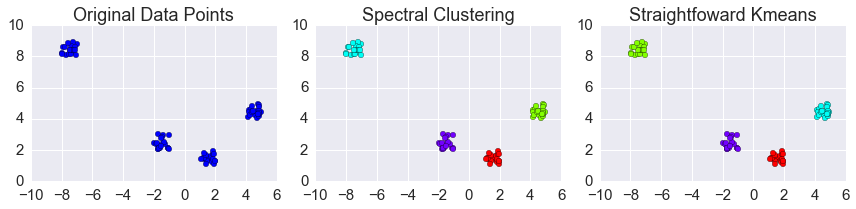

In [54]:
# Results from spectral clustering
IDX= Spectral(k,affinity)



# Results from k-means
clust_result = KMeans(n_clusters=k, random_state=10)
cluster_labels = clust_result.fit_predict(data)
indicator=np.loadtxt(cluster_labels,dtype='int32')
ID=indicator.tolist()
IDX_k=np.asarray(ID) 



# Draw graph
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.scatter(data[:,0],data[:,1],s=30)
plt.title('Original Data Points')

plt.subplot(1,3,2)
colors = plt.cm.hsv(np.linspace(0, 1, k+1))
for i in range(len(IDX)):
    for j in range(k):
        if IDX[i] == j:
            plt.scatter(data[i,0],data[i,1],c=colors[j] ,s=30)
plt.title('Spectral Clustering')


plt.subplot(1,3,3)
for i in range(len(IDX_k)):
    for j in range(k):
        if IDX_k[i] == j:
            plt.scatter(data[i,0],data[i,1],c=colors[j] ,s=30)
plt.title('Straightfoward Kmeans')
plt.tight_layout()

### Implementation (Special Case)
- Circular data

In [55]:
k=3
data = CreateCircle_jit(3)
affinity = CalculateAffinity_jit(data)

In [56]:
# Result from spectral clustering
IDX= Spectral(k,affinity)

# Result from k-means
clust_result = KMeans(n_clusters=3, random_state=10)
cluster_labels = clust_result.fit_predict(data)
indicator=np.loadtxt(cluster_labels,dtype='int32')
ID=indicator.tolist()
IDX_k=np.asarray(ID) 




- Moon-like data

In [57]:
moon = np.loadtxt('jain.txt')
data_m = moon[:,0:2]
affinity = CalculateAffinity_jit(data_m)
k_m = 2

In [58]:
# Result from spectral clustering
IDX_m=Spectral(k_m,affinity)

# Result from k-means
clust_result = KMeans(n_clusters=k_m, random_state=10)
cluster_labels = clust_result.fit_predict(data_m)
indicator=np.loadtxt(cluster_labels,dtype='int32')
ID=indicator.tolist()
IDX_mk=np.asarray(ID) 



- Draw Graph

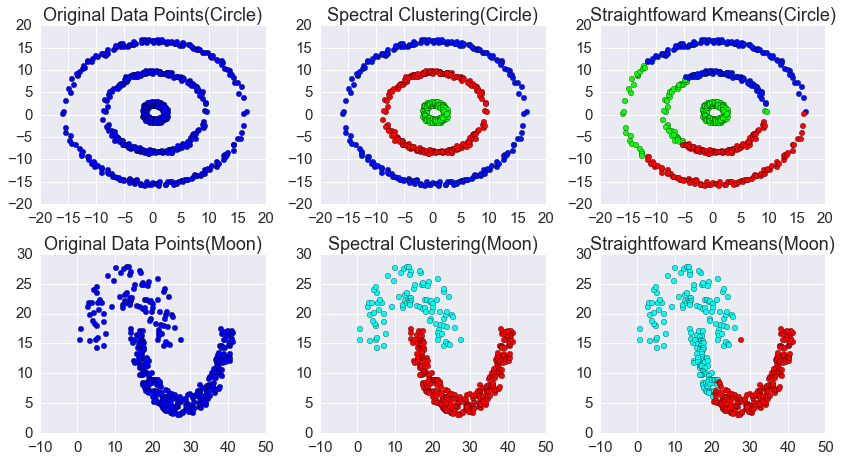

In [59]:
# Graph for circular data
plt.figure(figsize=(12,6.5))
plt.subplot(2,3,1)
plt.scatter(data[:,0],data[:,1],s=30)
plt.title('Original Data Points(Circle)')

plt.subplot(2,3,2)
colors = plt.cm.hsv(np.linspace(0, 1, k+1))
for i in range(len(IDX)):
    for j in range(k):
        if IDX[i] == j:
            plt.scatter(data[i,0],data[i,1],c=colors[j] ,s=30)
plt.title('Spectral Clustering(Circle)')


plt.subplot(2,3,3)
for i in range(len(IDX_k)):
    for j in range(k):
        if IDX_k[i] == j:
            plt.scatter(data[i,0],data[i,1],c=colors[j] ,s=30)
plt.title('Straightfoward Kmeans(Circle)')




# Graph for moon-like data data
plt.subplot(2,3,4)
plt.scatter(data_m[:,0],data_m[:,1],s=30)
plt.title('Original Data Points(Moon)')

plt.subplot(2,3,5)
colors = plt.cm.hsv(np.linspace(0, 1, k_m+1))
for i in range(len(IDX_m)):
    for j in range(k_m):
        if IDX_m[i] == j:
            plt.scatter(data_m[i,0],data_m[i,1],c=colors[j] ,s=30)
plt.title('Spectral Clustering(Moon)')


plt.subplot(2,3,6)
for i in range(len(IDX_mk)):
    for j in range(k_m):
        if IDX_mk[i] == j:
            plt.scatter(data_m[i,0],data_m[i,1],c=colors[j] ,s=30)
plt.title('Straightfoward Kmeans(Moon)')


plt.tight_layout()

